# Visualización de resultados de segmentación de imágenes con autoencoder variacional

Este taller es la continuación del [Taller de segmentación de Imágenes con VAE](taller_2_vae.ipynb).

Partiendo del VAE con el que se ha trabajado en el taller anterior, en esta ocasión vamos a visualizar los resultados de un VAE de un tamaño mayor entrenado con el dataset completo.

# Dataset

En este notebook hemos utilizado el dataset Cityscapes completo durante el entrenamiento en el que hemos mantenido la separación de clases utilizada en el taller anterior. Estas 7 clases son: vehículo, persona, suelo, edificios, vegetación, cielo y fondo (todo lo que no pertenezca a las otras clases). Posteriormente, para la inferencia, vamos a seguir usando el dataset minicityscapes debido a que es más ligero y apropiado para un tutorial.

![Cityscapes](https://raw.githubusercontent.com/SergioHdezG/TallerSegmentacionMUVA/master/imagenes/cityscapes.png)

In [2]:
import random

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten, Lambda
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras import backend as K
from tensorflow import keras
# from keras.engine import data_adapter
from utils import data_adapter

import os
import numpy as np
import matplotlib.pyplot as plt

## Preprocesado de datos
La siguiente celda solo es necesario ejecutarla si estás en google colab, desde binder omitela y omite también el enlace al dataset.

Este es un subconjunto del Cityscapes, añadelo a tu drive https://github.com/SergioHdezG/TallerSegmentacionMUVA/blob/master/datasets/minicityscapes.zip

En primer lugar tenemos que obtener acceso a nuestro google drive


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Si no has descomprimido el minicityscapes anteriormente, ejecuta la siguiente celda.

In [4]:
!unzip -u "datasets/minicityscapes.zip" -d "carpeta_destino"


Archive:  datasets/minicityscapes.zip


Cargamos los nombres de fichero y los ordenamos

In [5]:
data_path = "carpeta_destino/minicityscapes"

x = os.listdir(os.path.join(data_path, "train_images_npy"))
y = os.listdir(os.path.join(data_path, "train_masks_npy"))

# Ordenamos los nombres delos ficheros por sequencia
x.sort(key=lambda x: (x.split("f")[-1].split("_")[0], int(x.split("_")[1])))
y.sort(key=lambda x: (x.split("f")[-1].split("_")[0], int(x.split("_")[1])))

x = np.array(x)
y = np.array(y)

print('Training size: ', len(x))
print(x[:5])
print(y[:5])

Training size:  26
['f1_0_img.npy' 'f1_1_img.npy' 'f1_2_img.npy' 'f1_3_img.npy'
 'f1_4_img.npy']
['f1_0_msk.npy' 'f1_1_msk.npy' 'f1_2_msk.npy' 'f1_3_msk.npy'
 'f1_4_msk.npy']


In [6]:
# Esta función reordena las clases de la máscara para visualizar mejor los datos

def reorder_visulization(img_label):
    mask_fondo = np.copy(img_label[:, :, 0])
    mask_vehic = np.copy(img_label[:, :, 1])
    mask_suelo = np.copy(img_label[:, :, 2])
    mask_person = np.copy(img_label[:, :, 3])
    mask_edif = np.copy(img_label[:, :, 4])
    mask_veget = np.copy(img_label[:, :, 5])
    mask_cielo = np.copy(img_label[:, :, 6])

    img_label[:, :, 0] = mask_vehic
    img_label[:, :, 1] = mask_person
    img_label[:, :, 2] = mask_edif
    img_label[:, :, 3] = mask_veget
    img_label[:, :, 4] = mask_cielo
    img_label[:, :, 5] = mask_suelo
    img_label[:, :, 6] = mask_fondo

    return img_label

Cargamos los datos en un array.

In [7]:
x = [np.load(os.path.join(data_path, "train_images_npy", name)) for name in x]
y = [np.load(os.path.join(data_path, "train_masks_npy", name)) for name in y]
print('Training size: ', len(x))

Training size:  26


In [8]:
# Se convierte x_train a un numpy array
x = np.array(x)
y = np.array(y)

In [9]:
n_img = np.random.randint(0, x.shape[0])
img_in = x[n_img]
img_label = y[n_img]

print('Input image shape: ', img_in.shape)
print('Label image shape: ', img_label.shape)

print("Train images range: : [", np.amin(img_in), ", ", np.amax(img_in), "]")
print("Train label images range: : [", np.amin(img_label[:, :, 0]), ",", np.amax(img_label[:, :, 0]), "]")

Input image shape:  (256, 512, 3)
Label image shape:  (256, 512, 7)
Train images range: : [ 0.027450980392156862 ,  1.0 ]
Train label images range: : [ 0.0 , 0.0 ]


# Autoencoder Variacional

Definimos el VAE

In [10]:
def encoder(latent_dim, input_shape):
    inputs = Input(shape=input_shape, name='encoder_input')

    # Construimos el modelo de codificador
    x = Conv2D(filters=128,
               kernel_size=3,
               activation='relu',
               strides=2,
               padding='same')(inputs)

    # x = MaxPooling2D((2, 2))(x)
    x = Conv2D(filters=128,
               kernel_size=3,
               activation='relu',
               strides=2,
               padding='same')(x)

    # x = MaxPooling2D((2, 2))(x)
    x = Conv2D(filters=256,
               kernel_size=3,
               activation='relu',
               strides=2,
               padding='same')(x)

    # x = MaxPooling2D((2, 2))(x)
    x = Conv2D(filters=256,
               kernel_size=3,
               activation='relu',
               strides=2,
               padding='same')(x)

    x = Conv2D(filters=256,
               kernel_size=3,
               activation='relu',
               strides=2,
               padding='same')(x)

    # Necesitamos la información de las dimensiones de la salida de la última
    # capa convolucional para poder reconstruir la imagen al tamaño correcto en
    # el decodificador
    last_conv_shape = K.int_shape(x)

    # Generamos la huella latente
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)

    z_mean = Dense(latent_dim, name='z_mean', activation='linear')(x)
    z_log_var = Dense(latent_dim, name='z_log_var', activation='linear')(x)

    # Par usar una función externa en un modelo de Keras tenemos que hacerlo a 
    # través de una capa Lambda. La función sampling realiza el truco de la reparametrización
    # z = Lambda(sampling, name='z')([z_mean, z_log_var])
    z = Sampling()([z_mean, z_log_var])

    # instantiate encoder model
    encoder = tf.keras.models.Model(inputs, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()

    return encoder, last_conv_shape

In [11]:
def decoder(latent_dim, last_conv_shape, out_channels):
    # Construimos el modelo de decodificador
    latent_input = Input(shape=(latent_dim,), name='z_sampled')

    # shape = 4*8*8 = 584
    x = Dense(last_conv_shape[1] * last_conv_shape[2] * last_conv_shape[3], activation='relu')(latent_input)
    # shape = 584 => (4, 8, 8)
    x = Reshape((last_conv_shape[1], last_conv_shape[2], last_conv_shape[3]))(x)

    x = Conv2DTranspose(filters=256,
                        kernel_size=3,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

    x = Conv2DTranspose(filters=256,
                        kernel_size=3,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

    # x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(filters=256,
                        kernel_size=3,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

    # x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(filters=128,
                        kernel_size=3,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

    # x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(filters=128,
                        kernel_size=3,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

    output = Conv2DTranspose(filters=out_channels,
                          kernel_size=3,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)  # Activación sigmoide para que las salidas estén en rango [0, 1]



    # instantiate decoder model
    decoder = tf.keras.models.Model(latent_input, output, name='decoder')
    decoder.summary()

    return decoder

In [12]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta=0.5, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta  # Factor de importancia de la regulación (beta-VAE)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

        self.val_total_loss_tracker = keras.metrics.Mean(name="val_total_loss")
        self.val_reconstruction_loss_tracker = keras.metrics.Mean(
            name="val_reconstruction_loss"
        )
        self.val_kl_loss_tracker = keras.metrics.Mean(name="val_kl_loss")

        self.reconstruction_loss = None

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.val_total_loss_tracker,
            self.val_reconstruction_loss_tracker,
            self.val_kl_loss_tracker,
        ]

    def train_step(self, data):
        x, y, sample_weight = data_adapter.unpack_x_y_sample_weight(data)
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x, training=True)
            reconstruction = self.decoder(z, training=True)

            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(y, reconstruction))
            )

        total_loss, kl_loss = vae_loss_func(reconstruction_loss, z_log_var, z_mean, beta=beta)

        grads = tape.gradient(reconstruction_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(beta*kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "beta*kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        x, y, sample_weight = data_adapter.unpack_x_y_sample_weight(data)


        # Compute predictions
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)

        # Updates the metrics tracking the loss
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(y, reconstruction))
        )

        total_loss, kl_loss = vae_loss_func(reconstruction_loss, z_log_var, z_mean, beta=beta)

        # Update the metrics.
        self.val_total_loss_tracker.update_state(total_loss)
        self.val_reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.val_kl_loss_tracker.update_state(beta*kl_loss)

        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {
            "loss": self.val_total_loss_tracker.result(),
            "reconstruction_loss": self.val_reconstruction_loss_tracker.result(),
            "beta*kl_loss": self.val_kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

Definimos la función de muestreo:
z = z_mean + z_log_var * epsilon

In [13]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Definimos la función de pérdida del VAE

In [14]:
def vae_loss_func(reconstruction_loss, z_log_var, z_mean, beta=0.5):
    # Vamos a calcular la Kullback-Leibler dirvegence entre dos gaussianas
    # KL = 1/2 {(std_0/std_1)^2 + (mu_1-mu_0)^2/std_1^2 - 1 + ln(st_1^2/st_0^2)}
    # Se simplifica teniendo en cuenta que:
    # mu_0 = 0; std_0 = 1; std_1 = e^{log(std_1^2)/2} = e^z_log_var
    kl_loss = - 0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

    # beta: factor de importancia de la regulación (beta-VAE)
    vae_loss = tf.reduce_mean(reconstruction_loss + beta * kl_loss)

    return vae_loss, kl_loss

Construimos el modelo de VAE.
Seleccionamos el número de canales en función del número de etiquetas.

In [15]:
input_shape = (256, 512, 3)
out_channels= 7
latent_dim = 2048
beta = 1000

encoder, last_conv_shape = encoder(latent_dim, input_shape)
decoder = decoder(latent_dim, last_conv_shape, out_channels)


2022-12-15 13:41:17.047190: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 13:41:17.047662: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shernandez/.mujoco/mujoco210/bin:/usr/lib/nvidia
2022-12-15 13:41:17.047736: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shernandez/.mujoco/mujoco210/bin:/usr/lib/nvidia
2022-12-15 13:41:17.047809: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 256, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 256, 128 3584        encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 128, 128) 147584      conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 64, 256)  295168      conv2d_1[0][0]                   
____________________________________________________________________________________________

### Cargamos el VAE preentrenado

Normalmente, en Keras y otras bibliotecas similares, tendríamos que los datos de entrada son x_train y se introduce como etiquetas y_train, tal que:


Puedes descargar los pesos desde: https://urjc-my.sharepoint.com/:u:/g/personal/sergio_hernandez_urjc_es/EZFLXoyp7fFIj8TMkYfmz3IBX3GL7x11jWogIYm--cquCA?e=4wHfF8

In [16]:
encoder_path = 'checkpoints/taller_encoder/weights.h5'
decoder_path = 'checkpoints/taller_decoder/weights.h5'

# Cargamos los pesos del codificador
encoder.load_weights(encoder_path)

# Cargamos los pesos del decodificador
decoder.load_weights(decoder_path)

# Construimos el VAE
vae = VAE(encoder, decoder, beta)
vae.compile()

# Testing


Por último, vamos a visualizar algunos de los resultados.

La siguiente celda selecciona varias imágenes aleatorias y muestra el resultado que devuelve el modelo.

2022-12-15 13:41:32.886427: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


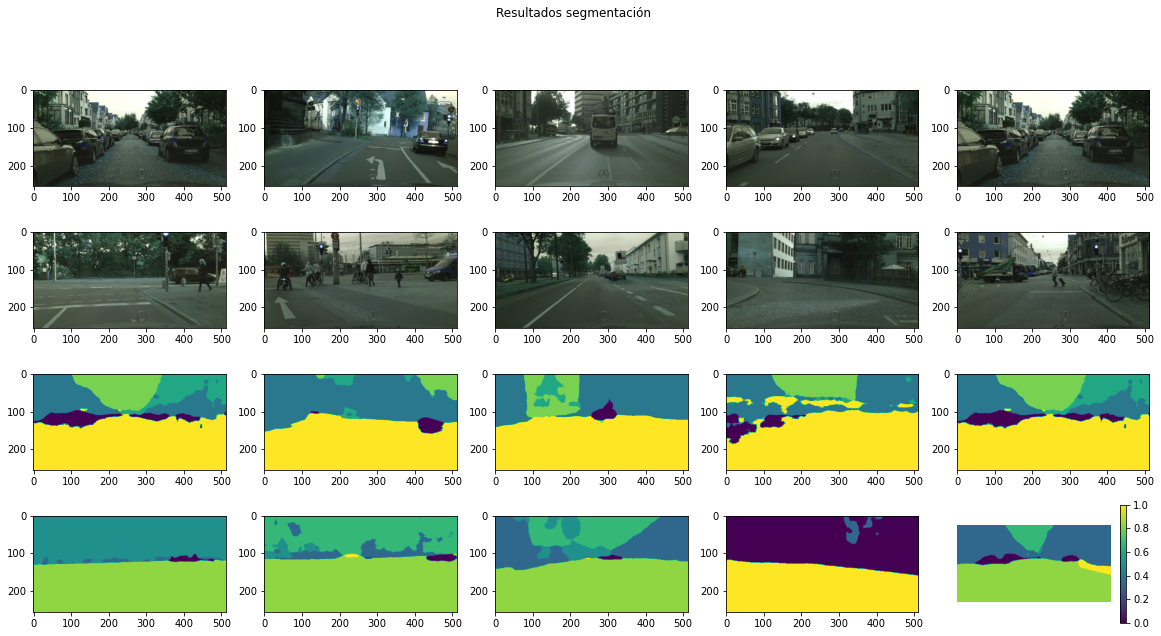

In [17]:
labels = ["vehículos", "persona", "edificios", "vegetación", "cielo", "suelo", "fondo"]

figsize = 5
num_examples_to_generate = figsize*figsize
fig = plt.figure(figsize=(20, 10))
fig.suptitle('Resultados segmentación')
examples_index = np.random.choice(x.shape[0], figsize*2)
examples = x[examples_index]
z_mean, z_log_var, z = encoder.predict(examples)
predictions = decoder.predict(z)


for i in range(figsize*2):
    preds = reorder_visulization(predictions[i])
    preds = np.argmax(preds, axis=-1) / 6.
    plt.subplot(4, figsize, i+1)
    plt.imshow(examples[i])
    plt.subplot(4, figsize, i + 1 + figsize*2)
    plt.imshow(preds)
plt.colorbar()
plt.axis('off')
plt.show()


A continuación, veamos cada una de las máscaras de segmentación que produce el modelo por separado.

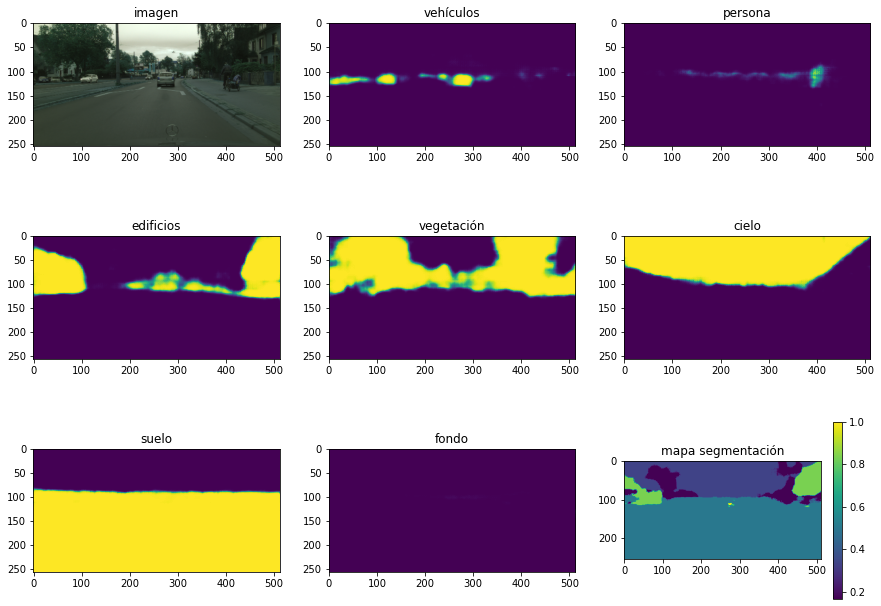

In [21]:
rnd = random.randint(0, predictions.shape[0]-1)
plt.figure(figsize=(15, 15))
ax = plt.subplot(4, 3, 1)
ax.set_title("imagen")
plt.imshow(examples[rnd])

# Mostramos cada máscara por separado
ax = plt.subplot(4, 3, 2)
ax.set_title(labels[0])
plt.imshow(predictions[rnd][:, :, 0])

ax = plt.subplot(4, 3, 3)
ax.set_title(labels[1])
plt.imshow(predictions[rnd][:, :, 1])

ax = plt.subplot(4, 3, 4)
ax.set_title(labels[2])
plt.imshow(predictions[rnd][:, :, 2])

ax = plt.subplot(4, 3, 5)
ax.set_title(labels[3])
plt.imshow(predictions[rnd][:, :, 3])

ax = plt.subplot(4, 3, 6)
ax.set_title(labels[4])
plt.imshow(predictions[rnd][:, :, 4])

ax = plt.subplot(4, 3, 7)
ax.set_title(labels[5])
plt.imshow(predictions[rnd][:, :, 5])

ax = plt.subplot(4, 3, 8)
ax.set_title(labels[6])
plt.imshow(predictions[rnd][:, :, 6])

# Generamos una imágen con todas las máscaras
preds = reorder_visulization(predictions[rnd])
img_all_label = np.argmax(preds, axis=-1) / 6.

ax = plt.subplot(4, 3, 9)
ax.set_title("mapa segmentación")
plt.imshow(img_all_label)
plt.colorbar()

plt.show()

Una característica interesante de los VAE es que son modelos generadores. Podemos crear una huella latente y ajustar sus parámetros para obtener imágenes nuevas.

Por ejemplo, con una red que segmente el tráfico, podríamos crear imágenes de segmentación de nuevas situaciones y a su vez utilizarlas para entrenar otro algoritmo en el manejo de un vehículo autónomo.

En la celda siguiente se muestrean varias huellas latentes sobre una distribución normal para crear nuevos ejemplos.



2022-12-15 10:56:04.253962: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1677721600 exceeds 10% of free system memory.


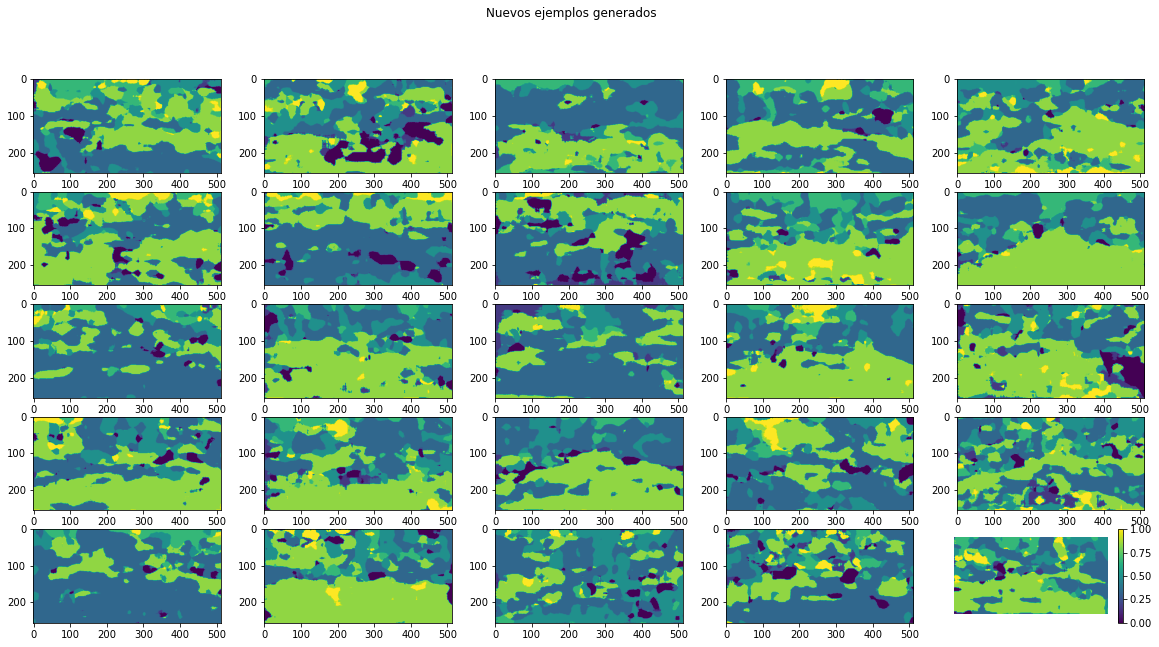

In [22]:
random_vector_for_generation = np.random.normal(size=(num_examples_to_generate, latent_dim))

predictions = decoder.predict(random_vector_for_generation)

fig = plt.figure(figsize=(20, 10))
fig.suptitle('Nuevos ejemplos generados')

for i in range(num_examples_to_generate):
    preds = reorder_visulization(predictions[i])
    preds = np.argmax(preds, axis=-1) / 6.
    plt.subplot(figsize, figsize, i + 1)
    plt.imshow(preds)
plt.colorbar()
plt.axis('off')
plt.show()

Por último, vamos a ver los valores de las huellas latentes que han generado las imágenes anteriores.

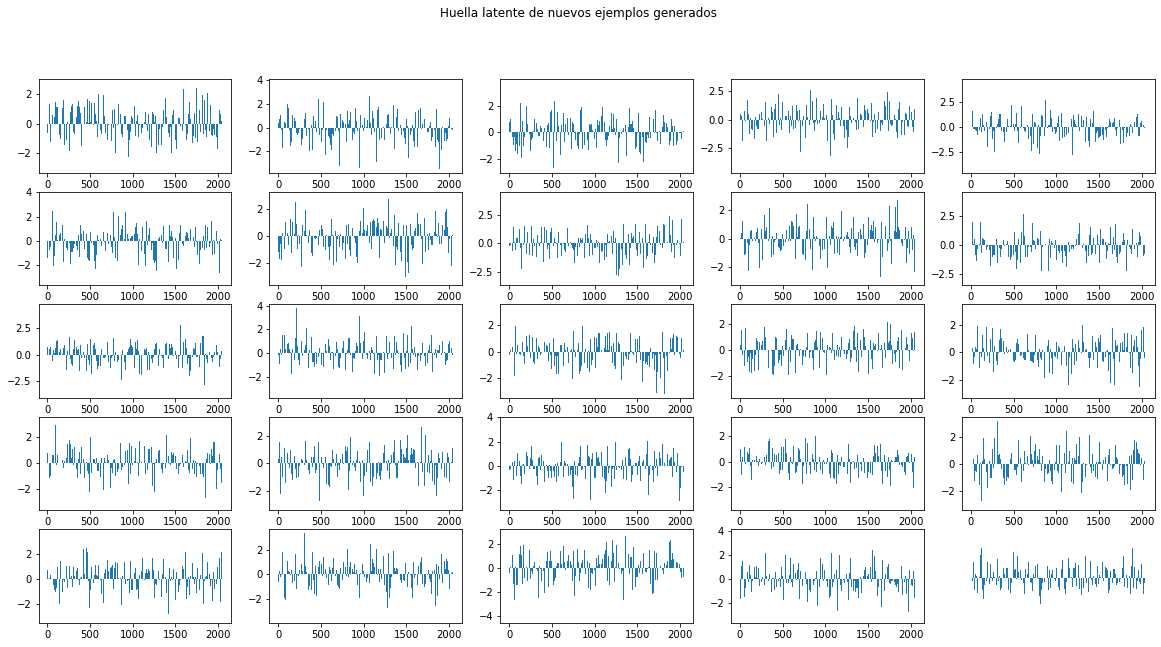

In [23]:
fig = plt.figure(figsize=(20, 10))
fig.suptitle('Huella latente de nuevos ejemplos generados')
lin_space = [n for n in range(latent_dim)]
for i in range(num_examples_to_generate):
    latent_data = random_vector_for_generation[i]
    plt.subplot(figsize, figsize, i + 1)
    plt.bar(lin_space, latent_data)

plt.axis('off')
plt.show()